# Import dependencies

In [1]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, extract
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to database

In [2]:
# Connect to sqlite database using SQLAlchemy ORM
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()
Measurement = Base.classes.measurement
Station = Base.classes.station

In [3]:
session = Session(engine)

## Temperature Analysis II

In [4]:
def calc_temps(start_date, end_date):
    results = session.query(Measurement.date, \
                            func.min(Measurement.tobs), \
                            func.avg(Measurement.tobs), \
                            func.max(Measurement.tobs)).\
                            group_by(Measurement.date).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date)
    
    df = pd.read_sql(results.statement, results.session.bind)
    min_temp = df["min_1"].min()
    avg_temp = df["avg_1"].mean()
    max_temp = df["max_1"].max()
    averages = {"min": [min_temp], "avg": [avg_temp], "max": [max_temp]}
    avg_df = pd.DataFrame(averages)
    return avg_df

In [5]:
df_2016 = calc_temps("2016-08-01", "2016-08-07")
df_2016

,min,avg,max
0,72.0,77.809524,83.0


In [6]:
df_2015 = calc_temps("2015-08-01", "2015-08-07")
df_2015

,min,avg,max
0,69.0,78.302041,85.0


In [7]:
min_list = list(df_2016["min"])
max_list = list(df_2016["max"])

yerr_list = [i-j for i,j in zip(max_list, min_list)]
yerr_list

[11.0]

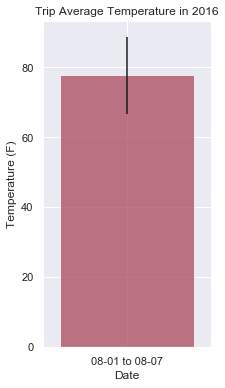

In [18]:
# Plot results as a bar chart per instructions in README
# Plot using 2016 Data

plt.figure(figsize=(3,6))
sns.set_style("darkgrid")
plot = sns.barplot(x=["08-01 to 08-07"], 
                   y=df_2016["avg"], 
                   palette="inferno", 
                   yerr=yerr_list, 
                   alpha=0.75)

plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.grid(True)
plt.title("Trip Average Temperature in 2016")
plt.show()

## Daily Rainfall Average

In [9]:
# Query rainfall per weather station for previous year (2016), sorted by precipitation
# Include station, name, latitude, longitude, and elevation
query = engine.execute("SELECT m.station, s.name, s.latitude, \
                        s.longitude, s.elevation, AVG(prcp) AS 'Average Rainfall' \
                        FROM measurement AS m \
                        INNER JOIN station AS s \
                        ON m.station = s.station \
                        WHERE m.date BETWEEN '2016-01-01' AND '2016-12-31' \
                        GROUP BY m.station").fetchall()
df_2 = pd.DataFrame(query)
daily_rain_2016 = df_2.rename(columns={0: "Station", 
                                       1: "Station_name", 
                                       2: "Latitude", 
                                       3: "Longitude", 
                                       4: "Elevation", 
                                       5: "Average_rain"})
daily_rain_2016

,Station,Station_name,Latitude,Longitude,Elevation,Average_rain
0,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.142486
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.094103
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.510596
3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,0.076154
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.218279
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.044368
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.094677


## Daily Temperature Normals

In [10]:
def daily_normals(start_date, end_date):
    results = session.query(Measurement.date, \
                            func.min(Measurement.tobs), \
                            func.avg(Measurement.tobs), \
                            func.max(Measurement.tobs)).\
                            group_by(Measurement.date).\
                            filter(Measurement.date >= start_date).\
                            filter(Measurement.date <= end_date)
    
    return results

In [11]:
# Calculate the daily normals for each day of your trip (inclusive)
start_date = '2017-08-01'
end_date = '2017-08-07'
trip = daily_normals(start_date, end_date)
trip.all()

[('2017-08-01', 72.0, 74.5, 77.0),
 ('2017-08-02', 73.0, 79.0, 83.0),
 ('2017-08-03', 76.0, 79.0, 81.0),
 ('2017-08-04', 77.0, 80.0, 82.0),
 ('2017-08-05', 77.0, 80.0, 82.0),
 ('2017-08-06', 79.0, 81.4, 83.0),
 ('2017-08-07', 78.0, 80.5, 83.0)]

In [12]:
# Load results into a dataframe per README instructions
trip_df = pd.read_sql(trip.statement, trip.session.bind)
trip_df

,date,min_1,avg_1,max_1
0,2017-08-01,72.0,74.5,77.0
1,2017-08-02,73.0,79.0,83.0
2,2017-08-03,76.0,79.0,81.0
3,2017-08-04,77.0,80.0,82.0
4,2017-08-05,77.0,80.0,82.0
5,2017-08-06,79.0,81.4,83.0
6,2017-08-07,78.0,80.5,83.0


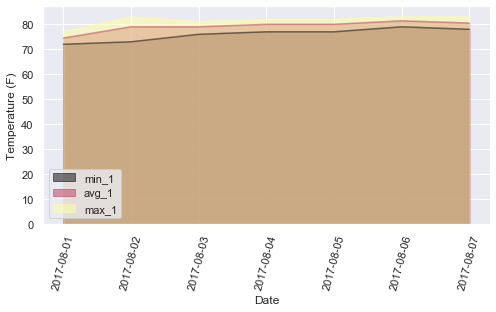

In [17]:
# Plot the daily normals as an area plot with `stacked=False`

sns.set_theme(style="darkgrid")

trip_df.plot(kind="area", stacked=False, figsize=(8,4), colormap="inferno")
plt.xticks(range(len(trip_df.date)), trip_df.date, rotation=75)
plt.xlabel("Date")
plt.ylabel("Temperature (F)")
plt.grid(True)
plt.show()

## Close Session

In [19]:
session.close()